# driver_DD_LSROM
Driver to test and evaluate the DD-LS-ROM on the 2D Burgers' equation.   

In [1]:
import numpy as np
import scipy.linalg as la
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
import dill as pickle
from time import time
import os

from utils.Burgers2D_probgen import Burgers2D
from utils.domain_decomposition import DD_model
from utils.LS_ROM import compute_bases, DD_LS_ROM, save_svd_data, compute_bases_from_svd

In [2]:
data_dir = './data/'
plt.rc('font', size=20)
plt.rcParams['text.usetex'] = True

## Build full-domain FOM and DD-FOM

In [3]:
# define constant parameters for PDE
nx, ny  = 480, 24
x_lim   = [-1.0, 1.0]
y_lim   = [0.0, 0.05]

na1, nlam = 80, 80
a1_lim  = [1.0, 10000.0]
lam_lim = [5.0, 25.0]
A, Lam  = np.meshgrid(np.linspace(a1_lim[0], a1_lim[1], na1), np.linspace(lam_lim[0], lam_lim[1], nlam))
Mu      = np.vstack([A.flatten(), Lam.flatten()]).T

a1, lam = 7692.5384, 21.9230
# a1, lam = 1.0, 25.0
# a1, lam = np.trunc(np.random.uniform(1.0, 1e4)*1e4)/1e4, np.trunc(np.random.uniform(5.0, 25.0)*1e4)/1e4
viscosity = 0.1

print(f'a1, lam = {a1, lam}')

# number of subdomains in x and y directions for DD model
n_sub_x = 2
n_sub_y = 1

n_sub   = n_sub_x*n_sub_y
Ntotal = 6400 if nx in [240, 480] else 4200
fig_dir  = f'./figures/nx_{nx}_ny_{ny}_mu_{viscosity}_{n_sub_x}x_by_{n_sub_y}y/a1_{a1}_lam_{lam}/'
svd_dir  = f'./data/nx_{nx}_ny_{ny}_mu_{viscosity}_{n_sub_x}x_by_{n_sub_y}y/'
ls_figs = fig_dir + 'lsrom/'
for d in [fig_dir, ls_figs, svd_dir]:
    if not os.path.exists(d):
        os.mkdir(d)

a1, lam = (7692.5384, 21.923)


In [4]:
# compute FOM for given a1 and lambda
def u_exact(x, y):
    phi = a1 + a1*x + (np.exp(lam*(x-1.0)) + np.exp(-lam*(x - 1.0)))*np.cos(lam*y)
    val = -2.0*viscosity*(a1 + lam*(np.exp(lam*(x-1.0)) \
          - np.exp(-lam*(x - 1.0)))*np.cos(lam*y))/phi
    return val
def v_exact(x, y):
    phi = a1 + a1*x + (np.exp(lam*(x-1.0)) + np.exp(-lam*(x - 1.0)))*np.cos(lam*y)
    val =  2.0*viscosity*(lam*(np.exp(lam*(x-1.0)) \
           + np.exp(-lam*(x - 1.0)))*np.sin(lam*y))/phi
    return val

# generate Burgers FOM on full domain
fom = Burgers2D(nx, ny, x_lim, y_lim, viscosity, u_exact, v_exact)
print('Solving full domain model:')
u_fom, v_fom, res_hist = fom.solve(np.zeros(fom.nxy), np.zeros(fom.nxy), tol=1e-8, print_hist=False)
sol_fd = np.concatenate([u_fom, v_fom])

# compute Burgers DD FOM
ddmdl = DD_model(fom, n_sub_x, n_sub_y)
ndof_fom = 2*np.sum([s.n_interior+s.n_interface for s in ddmdl.subdomain]) \
            + ddmdl.subdomain[0].constraint_mat.shape[0]
w0 = np.zeros(ndof_fom)
print('\nSolving DD model:')
print(f'FOM DoF = {ndof_fom-ddmdl.n_constraints}')
u_dd_fom, v_dd_fom, u_intr, v_intr, u_intf, v_intf, lam_fom, fom_time, itr = ddmdl.solve(w0, tol=1e-4, 
                                                                           maxit=15,
                                                                           print_hist=True)
sol_dd_fom = np.concatenate([u_dd_fom, v_dd_fom])

dd_fom_rel_err = np.linalg.norm(sol_dd_fom-sol_fd)/np.linalg.norm(sol_fd)
print(f'\nDD-FOM relative error = {dd_fom_rel_err:1.4e}') 

Solving full domain model:
Starting Newton solver...
Newton solver terminated after 14 iterations with residual 5.9127e-09.

Solving DD model:
FOM DoF = 23136
Starting Newton solver...
iter       Stepsize       Residual
   0       0.000e+00      2.815e+11
   1       1.000e+00      8.855e+09
   2       1.000e+00      1.272e+09
   3       1.000e+00      1.318e+08
   4       1.000e+00      1.119e+07
   5       1.000e+00      9.497e+05
   6       1.000e+00      8.095e+04
   7       1.000e+00      6.929e+03
   8       1.000e+00      5.963e+02
   9       1.000e+00      5.165e+01
  10       1.000e+00      4.507e+00
  11       1.000e+00      3.967e-01
  12       1.000e+00      3.526e-02
  13       1.000e+00      3.170e-03
  14       1.000e+00      3.539e-04
  15       1.000e+00      2.083e-04
Newton failed to converge in 15 iterations.
Newton solver terminated after 15 iterations with residual 2.0829e-04.

DD-FOM relative error = 8.4840e-16


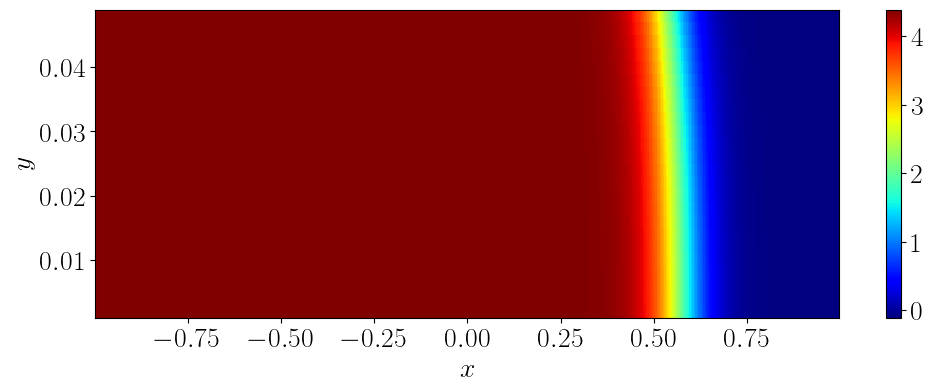

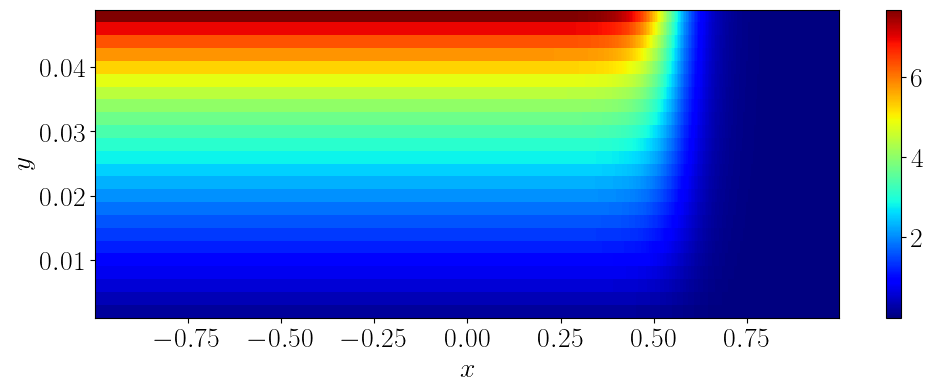

In [5]:
# plot DD FOM u and v
x = np.linspace(x_lim[0], x_lim[1], nx+2)[1:-1]
y = np.linspace(y_lim[0], y_lim[1], ny+2)[1:-1]
X, Y = np.meshgrid(x, y)
U_fom = u_dd_fom.reshape(ny, nx)
V_fom = v_dd_fom.reshape(ny, nx)

plt.figure(figsize=(12, 4))
plt.pcolormesh(X, Y, U_fom, cmap=cm.jet, shading='auto', vmin=u_fom.min(), vmax=u_fom.max())
plt.xlabel('$x$')
plt.ylabel('$y$')
cb = plt.colorbar()#label='$u(x, y)$')
file = fig_dir+'u_fom.png'
plt.savefig(file, bbox_inches='tight', pad_inches=0.1)
plt.show()

plt.figure(figsize=(12, 4))
plt.pcolormesh(X, Y, V_fom, cmap=cm.jet, shading='auto', vmin=v_fom.min(), vmax=v_fom.max())
plt.xlabel('$x$')
plt.ylabel('$y$')
cb = plt.colorbar()#label='$v(x, y)$')
file = fig_dir+'v_fom.png'
plt.savefig(file, bbox_inches='tight', pad_inches=0.1)
plt.show()

## Compute DD-LS-ROM 

In [6]:
# energy criteria for number of interior and interface basis vectors
ec_res  = 1e-10
ec_intr = 1e-6
ec_intf = 1e-6
ec_port = 1e-6

# number of interior and interface basis vectors. set to -1 to use energy criteria
nbasis_res = -1
nbasis_intr = 6
nbasis_intf = 4
nbasis_port = 3   # size of basis per port 

In [7]:
# compute SVD for snapshots/residuals for each subdomain 
nsnaps = Ntotal
if not os.path.exists(svd_dir+f'port_svd_nsnaps_{nsnaps}.p'):
    # load snapshot and residual data
    print('Loading snapshot data...')
    file = f'./data/residual_nx_{nx}_ny_{ny}_mu_{viscosity}_Nsamples_400.p'
    data = pickle.load(open(file, 'rb'))
    Mu = data['parameters']
    residuals = data['residuals']

    # load snapshot and residual data
    file = f'./data/snapshot_nx_{nx}_ny_{ny}_mu_{viscosity}_Nsamples_{Ntotal}.p'
    data = pickle.load(open(file, 'rb'))
    Mu = data['parameters']
    snapshots = data['snapshots']
    print('Data loaded!')
    
    print('Saving SVD data...')
    save_svd_data(ddmdl, snapshots, residuals, save_dir=svd_dir, nsnaps=nsnaps)
    print('SVD data saved!')
    
# load SVD data
print('Loading SVD data...')
intr_dict = pickle.load(open(svd_dir+f'intr_svd_nsnaps_{nsnaps}.p', 'rb'))
intf_dict = pickle.load(open(svd_dir+f'intf_svd_nsnaps_{nsnaps}.p', 'rb'))
port_dict = pickle.load(open(svd_dir+f'port_svd_nsnaps_{nsnaps}.p', 'rb'))
res_dict  = pickle.load(open(svd_dir+'res_svd.p', 'rb'))
print('Data loaded!')

# compute bases
print('Computing bases...')
interior_bases  = compute_bases_from_svd(intr_dict, ec=ec_intr, nbasis=nbasis_intr)
interface_bases = compute_bases_from_svd(intf_dict, ec=ec_intf, nbasis=nbasis_intf)
port_bases      = compute_bases_from_svd(port_dict, ec=ec_port, nbasis=nbasis_port)
residual_bases  = compute_bases_from_svd(res_dict, ec=ec_res, nbasis=nbasis_res)
print('Bases computed!')

for i in range(n_sub):
    print(f'residual_bases[{i}]={residual_bases[i].shape}')
for i in range(n_sub):
    print(f'interior_bases[{i}]={interior_bases[i].shape}') 
for i in range(n_sub):
    print(f'interface_bases[{i}]={interface_bases[i].shape}')
for i in range(len(ddmdl.ports)):
    print(f'port_bases[{i}]={port_bases[i].shape}') 

Loading SVD data...
Data loaded!
Computing bases...
Bases computed!
residual_bases[0]=(11520, 27)
residual_bases[1]=(11520, 72)
interior_bases[0]=(11472, 6)
interior_bases[1]=(11472, 6)
interface_bases[0]=(96, 4)
interface_bases[1]=(96, 4)
port_bases[0]=(96, 3)


In [8]:
if nbasis_port > 0:    
    pb_dim = [min(len(ddmdl.port_dict[p]-1), nbasis_port) for p in ddmdl.ports]
    for i, p in enumerate(port_bases): 
        port_bases[i] = p[:, :pb_dim[i]]
        print(f'Port {i} basis size = {port_bases[i].shape}')

Port 0 basis size = (96, 3)


In [9]:
# compute DD LS-ROM
print('Building DD LS-ROM...')
ddlsrom = DD_LS_ROM(ddmdl, residual_bases, interior_bases, interface_bases, 
                    port_bases=port_bases,
                    hr=True,
                    hr_type='collocation',
                    sample_ratio=2, 
                    n_samples=-1,
                    n_corners=-1,
                    constraint_type='strong', 
                    n_constraints=1, 
                    seed=1)
print('ROM built!\n')

# solve DD ROM
print('Solving DD LS-ROM...')
ndof_rom = np.sum([s.n_interior+s.n_interface for s in ddlsrom.subdomain]) \
            + ddlsrom.n_constraints
print(f'ROM DoF = {ndof_rom-ddlsrom.n_constraints}')
w0 = np.zeros(ndof_rom)
u_dd_rom, v_dd_rom, w_intr, w_intf, lam_opt, rom_time, itr, rhs_vecs = \
                                         ddlsrom.solve(w0, tol=1e-4, maxit=15, print_hist=True, rhs_hist=True)
print('Solution found!\n')

# compute error
dd_rom_rel_err = ddlsrom.compute_error(w_intr, w_intf, u_intr, v_intr, u_intf, v_intf)
print(f'DD-ROM rel. error = {dd_rom_rel_err:1.4e}')
print(f'Speedup = {fom_time/rom_time}')

Building DD LS-ROM...
ROM built!

Solving DD LS-ROM...
ROM DoF = 18
Starting Newton solver...
iter       Stepsize       Residual
   0       0.000e+00      9.430e+09
   1       1.000e+00      4.609e+08
   2       1.000e+00      1.281e+06
   3       1.000e+00      2.163e+02
   4       1.000e+00      1.736e-01
   5       1.000e+00      1.760e-04
   6       1.000e+00      8.280e-07
Newton solver terminated after 6 iterations with residual 8.2795e-07.
Solution found!

DD-ROM rel. error = 1.2542e-02
Speedup = 168.2346568418745


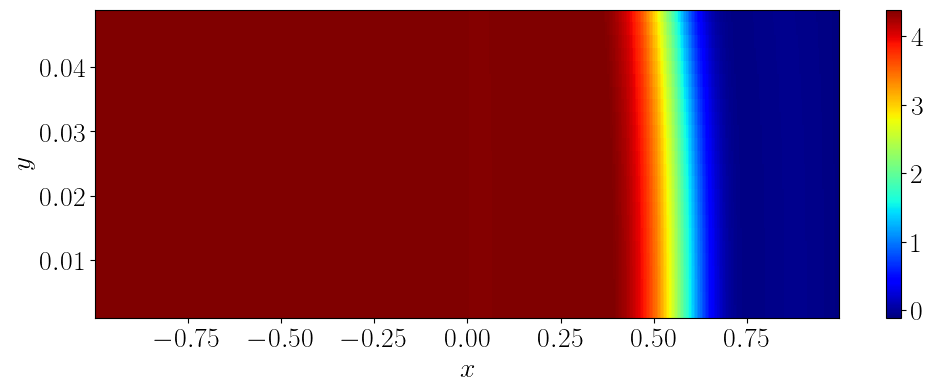

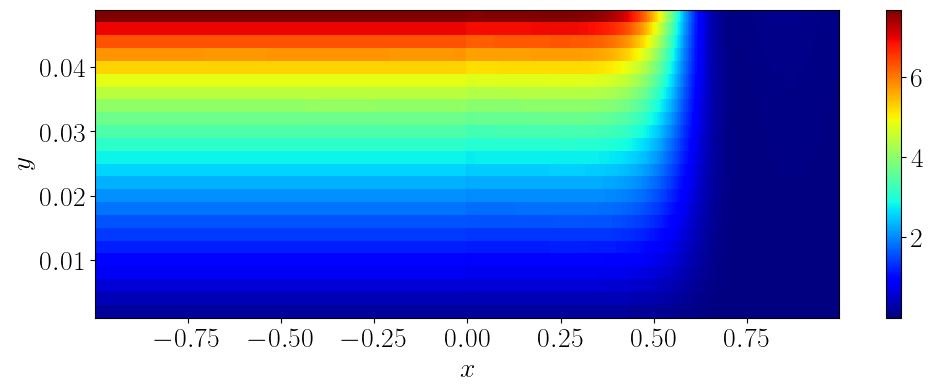

In [10]:
# plot DD ROM u and v
hr_str = '_col_hr' if ddlsrom.hr else ''
ct_str = '_srpc' if ddlsrom.constraint_type == 'strong' else '_wfpc'

x = np.linspace(x_lim[0], x_lim[1], nx+2)[1:-1]
y = np.linspace(y_lim[0], y_lim[1], ny+2)[1:-1]
X, Y = np.meshgrid(x, y)
U_rom = u_dd_rom.reshape(ny, nx)
V_rom = v_dd_rom.reshape(ny, nx)

plt.figure(figsize=(12, 4))
plt.pcolormesh(X, Y, U_rom, cmap=cm.jet, shading='auto', vmin=u_fom.min(), vmax=u_fom.max())
plt.xlabel('$x$')
plt.ylabel('$y$')
cb = plt.colorbar()#label='$u(x, y)$')
file = ls_figs+f'u{ct_str}{hr_str}_state.png'
plt.savefig(file, bbox_inches='tight', pad_inches=0.1)
plt.show()

plt.figure(figsize=(12, 4))
plt.pcolormesh(X, Y, V_rom, cmap=cm.jet, shading='auto', vmin=v_fom.min(), vmax=v_fom.max())
plt.xlabel('$x$')
plt.ylabel('$y$')
cb = plt.colorbar()#label='$v(x, y)$')
file = ls_figs+f'v{ct_str}{hr_str}_state.png'
plt.savefig(file, bbox_inches='tight', pad_inches=0.1)
plt.show()

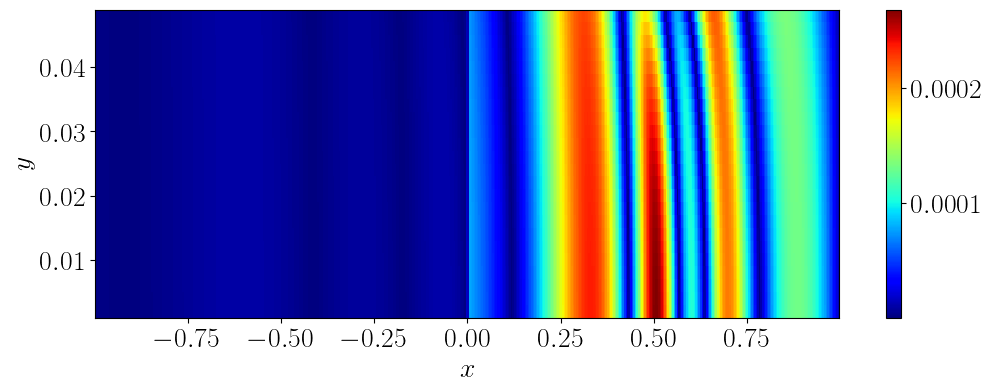

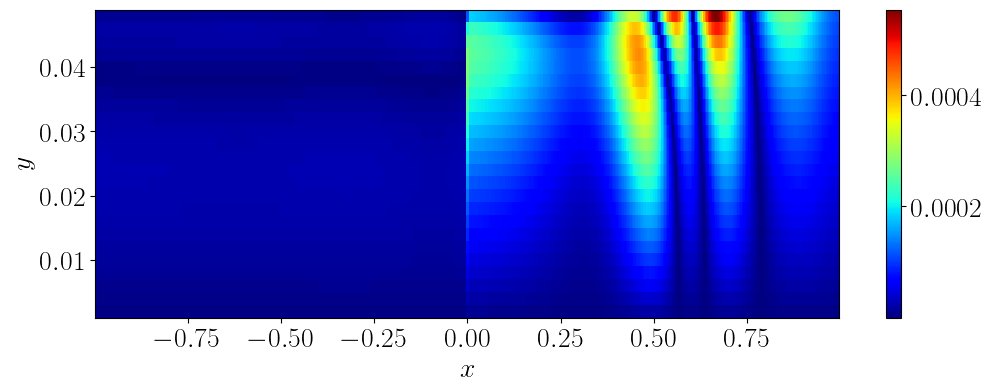

In [11]:
# plot errors
u_rel_err = np.abs(U_fom-U_rom)/np.linalg.norm(U_fom)
plt.figure(figsize=(12, 4))
plt.pcolormesh(X, Y, u_rel_err, cmap=cm.jet, shading='auto')#, vmin=0.0, vmax=4.88e-4)
plt.xlabel('$x$')
plt.ylabel('$y$')
cb = plt.colorbar()#label='$u$ Relative error')
file = ls_figs+f'u{ct_str}{hr_str}_rel_error.png'
plt.savefig(file, bbox_inches='tight', pad_inches=0.1)
plt.show()

plt.figure(figsize=(12, 4))
v_rel_err = np.abs(V_fom-V_rom)/np.linalg.norm(V_fom)
plt.pcolormesh(X, Y, v_rel_err, cmap=cm.jet, shading='auto')#, vmin=0.0, vmax=4.88e-4)
plt.xlabel('$x$')
plt.ylabel('$y$')
cb = plt.colorbar()#label='$v$ Relative error')
file = ls_figs+f'v{ct_str}{hr_str}_rel_error.png'
plt.savefig(file, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [12]:
# check that SRPC and WFPC are satisfied
cres_rp = np.zeros(ddlsrom.n_constraints)
cres_fp = np.zeros(ddmdl.n_constraints)
ct_str1 = 'WFPC' if ddlsrom.constraint_type == 'weak' else 'SRPC'
for i, s in enumerate(ddlsrom.subdomain):
    cres_rp += s.constraint_mat@w_intf[i]
    cres_fp += ddmdl.subdomain[i].constraint_mat@s.intf_basis@w_intf[i]
print(f'ROM-port constraint residual ({ct_str1}) = {np.linalg.norm(cres_rp):1.4e}')
print(f'FOM-port constraint residual ({ct_str1}) = {np.linalg.norm(cres_fp):1.4e}')

ROM-port constraint residual (SRPC) = 0.0000e+00
FOM-port constraint residual (SRPC) = 0.0000e+00


In [13]:
for i, s in enumerate(ddlsrom.subdomain):
    print(f'Subdomain {i} interface dimension = {s.intf_basis.shape[1]}')

Subdomain 0 interface dimension = 3
Subdomain 1 interface dimension = 3


In [14]:
for i, s in enumerate(ddlsrom.subdomain):
    print(f'Subdomain {i} interior dimension = {s.intr_basis.shape[1]}')

Subdomain 0 interior dimension = 6
Subdomain 1 interior dimension = 6


In [15]:
# compute lagrange multiplier approximation
lam_rom_approx = ddlsrom.subdomain[0].intf_basis@lam_opt

# compute error estimate
xtilde = []
for i, s in enumerate(ddlsrom.subdomain):
    xtilde.append(s.intr_basis@w_intr[i])
    xtilde.append(s.intf_basis@w_intf[i])
xtilde.append(lam_rom_approx)
xtilde = np.concatenate(xtilde)

f, j, rt = ddmdl.FJac(xtilde)
e = np.linalg.norm(sp.linalg.spsolve(j, f))

print(f'norm of FOM lagrange mult. = {np.linalg.norm(lam_fom):1.4e}')
print(f'norm of ROM lagrange mult. = {np.linalg.norm(lam_rom_approx):1.4e}')
print(f'Lagrange mult. error       = {np.linalg.norm(lam_fom-lam_rom_approx):1.4e}')
print(f"||(F'(Vx))^(-1)F(Vx)||     = {np.linalg.norm(e):1.4e}")

norm of FOM lagrange mult. = 1.6168e-20
norm of ROM lagrange mult. = 6.4168e+06
Lagrange mult. error       = 6.4168e+06
||(F'(Vx))^(-1)F(Vx)||     = 6.4168e+06


In [17]:
ddlsrom.subdomain[0].hxy

8.316008316008316e-06

## Check reconstruction error

In [15]:
error = 0.0
intr_errors = []
intf_errors = []

for i, s in enumerate(ddlsrom.subdomain):
    uv_intr = np.concatenate([u_intr[i], v_intr[i]])
    uv_intf = np.concatenate([u_intf[i], v_intf[i]])
    
    num_intr = np.sum(np.square
                      (uv_intr - s.intr_basis@(s.intr_basis.T@uv_intr))) 
    num_intf = np.sum(np.square(uv_intf - s.intf_basis@(s.intf_basis.T@uv_intf))) 
    den_intr = np.sum(np.square(uv_intr)) 
    den_intf =  np.sum(np.square(uv_intf)) 
    intr_errors.append(num_intr/den_intr)
    intf_errors.append(num_intf/den_intf)
    error += (num_intr+num_intf)/(den_intr+den_intf)
error = np.sqrt(error/ddlsrom.n_sub)
print(f'Relative reconstruction error = {error:1.4e}')
print('Subdomain     Intr. rel. error     Intf. rel. error')
for i in range(n_sub):
    print(f'    {i+1:2d}           {intr_errors[i]:1.4e}           {intf_errors[i]:1.4e}') 

Relative reconstruction error = 3.9686e-02
Subdomain     Intr. rel. error     Intf. rel. error
     1           8.9412e-12           7.6608e-05
     2           4.7062e-11           1.3186e-04
     3           5.6549e-11           1.2226e-04
     4           5.6808e-10           1.0361e-04
     5           4.8509e-08           6.7108e-05
     6           7.6038e-07           6.1214e-05
     7           4.4392e-05           3.2374e-03
     8           3.0615e-07           7.3108e-02
     9           7.5013e-12           9.0351e-05
    10           3.0279e-11           1.4203e-04
    11           8.9526e-11           1.3431e-04
    12           1.6580e-08           1.1872e-04
    13           1.1627e-07           8.5950e-05
    14           2.4449e-06           1.2065e-04
    15           7.7265e-05           2.6410e-03
    16           5.0173e-06           6.8399e-02


## Analyze behavior of residual at FOM and ROM solutions

In [16]:
# compute ROM residual, equality constraint
Ag_rom = np.zeros(ddlsrom.n_constraints)
res_rom = 0.0
res_list = []
for j, s in enumerate(ddlsrom.subdomain):
    res_list.append(s.res_jac(w_intr[j], w_intf[j], lam_opt)[0])
    res_rom += np.linalg.norm(res_list[j])**2
    Ag_rom += s.constraint_mat@w_intf[j]
res_rom *= 0.5

# compute FOM residual, equality constraint
Ag_fom  = np.zeros(ddmdl.n_constraints)
res_fom = 0.0
for j, s in enumerate(ddmdl.subdomain):
    res_fom += np.linalg.norm(s.res_jac(u_intr[j], v_intr[j], u_intf[j], v_intf[j], lam_fom)[0])**2
    Ag_fom += s.constraint_mat@np.concatenate([u_intf[j], v_intf[j]])
res_fom *= 0.5

print(f'ROM LSTSQ residual  = {res_rom:1.4e}')
print(f'ROM constraint norm = {np.linalg.norm(Ag_rom):1.4e}')
print(f'FOM LSTSQ residual  = {res_fom:1.4e}')
print(f'FOM constraint norm = {np.linalg.norm(Ag_fom):1.4e}')

ROM LSTSQ residual  = 1.2372e+09
ROM constraint norm = 0.0000e+00
FOM LSTSQ residual  = 3.9272e-18
FOM constraint norm = 0.0000e+00


In [17]:
# compute residual, constraint at projected FOM solution 
Ag_pr = np.zeros(ddlsrom.n_constraints)
res_pr = 0.0
pr_res_list = []
for j, s in enumerate(ddlsrom.subdomain):
    pr_uv_intr = s.intr_basis.T@np.concatenate((u_intr[j], v_intr[j]))
    pr_uv_intf = s.intf_basis.T@np.concatenate((u_intf[j], v_intf[j]))
    
    pr_res_list.append(s.res_jac(pr_uv_intr, pr_uv_intf, lam_opt)[0])
    res_pr += np.linalg.norm(pr_res_list[j])**2
    Ag_pr += s.constraint_mat@pr_uv_intf
res_pr *= 0.5
print(f'ROM LSTSQ residual at projected FOM sol.  = {res_pr:1.4e}')
print(f'ROM constraint norm at projected FOM sol. = {np.linalg.norm(Ag_pr):1.4e}')

ROM LSTSQ residual at projected FOM sol.  = 3.2067e+09
ROM constraint norm at projected FOM sol. = 5.2907e-14


In [18]:
x_err_list = []
res_fom_list = []
res_pr_list = []
RTr_fom_list = []
RTr_pr_list = []
for j, s in enumerate(ddmdl.subdomain):
    res, jac, H, rhs, Ax = s.res_jac(u_intr[j], v_intr[j], u_intf[j], v_intf[j], lam_fom)
    RTr = jac.T@res #np.concatenate([jac_intr.T@res, jac_intf.T@res])
    RTr_fom_list.append(np.linalg.norm(RTr))
    res_fom_list.append(np.linalg.norm(res))
    
    uv_intr_pr = np.concatenate((u_intr[j], v_intr[j]))
    uv_intf_pr = np.concatenate((u_intf[j], v_intf[j]))
    
    uv_intr_pr = ddlsrom.subdomain[j].intr_basis@ddlsrom.subdomain[j].intr_basis.T@uv_intr_pr
    uv_intf_pr = ddlsrom.subdomain[j].intf_basis@ddlsrom.subdomain[j].intf_basis.T@uv_intf_pr
    
    u_intr_pr = uv_intr_pr[:s.n_interior]
    v_intr_pr = uv_intr_pr[s.n_interior:] 
    u_intf_pr = uv_intf_pr[:s.n_interface]
    v_intf_pr = uv_intf_pr[s.n_interface:]
    
    res, jac, H, rhs, Ax = s.res_jac(u_intr_pr, v_intr_pr, u_intf_pr, v_intf_pr, lam_fom)
    RTr = jac.T@res #np.concatenate([jac_intr.T@res, jac_intf.T@res])
    RTr_pr_list.append(np.linalg.norm(RTr))
    res_pr_list.append(np.linalg.norm(res))
    
    x_err_list.append(np.linalg.norm(np.concatenate([u_intr[j], v_intr[j], u_intf[j], v_intf[j]])-
                                    np.concatenate([uv_intr_pr, uv_intf_pr])))
    
print(f"sub.     ||x-x_pr|||    ||r(x)||      ||r(x_pr)||     ||R'(x)^Tr(x)||    ||R'(x_pr)^Tr(x_pr)||")
for j in range(n_sub):
    print(f' {j:d}       {x_err_list[j]:1.3e}      {res_fom_list[j]:1.3e}     {res_pr_list[j]:1.3e}       {RTr_fom_list[j]:1.3e}          {RTr_pr_list[j]:1.3e}')    

sub.     ||x-x_pr|||    ||r(x)||      ||r(x_pr)||     ||R'(x)^Tr(x)||    ||R'(x_pr)^Tr(x_pr)||
 0       5.296e-01      5.375e-10     1.180e+04       4.949e-05          1.072e+09
 1       7.398e-01      6.327e-10     1.633e+04       5.940e-05          1.486e+09
 2       7.124e-01      6.278e-10     1.574e+04       5.927e-05          1.431e+09
 3       6.558e-01      6.146e-10     1.452e+04       5.866e-05          1.319e+09
 4       5.283e-01      6.202e-10     1.182e+04       5.833e-05          1.069e+09
 5       4.902e-01      5.732e-10     1.066e+04       5.378e-05          8.928e+08
 6       1.640e+00      2.041e-10     3.910e+04       1.925e-05          3.121e+09
 7       2.907e-01      9.450e-12     7.028e+03       8.639e-07          5.686e+08
 8       6.179e-01      1.014e-09     1.295e+04       8.862e-05          1.114e+09
 9       8.660e-01      9.178e-10     1.795e+04       8.548e-05          1.544e+09
 10       8.421e-01      9.437e-10     1.734e+04       8.749e-05          1

In [19]:
print(f"itr     ||R'*r||         ||Ag(x)||")
for j, r in enumerate(rhs_vecs):
    Rr = np.linalg.norm(r[:-ddlsrom.n_constraints])
    Ag = np.linalg.norm(r[-ddlsrom.n_constraints:])    
    print(f' {j:2d}     {Rr:1.6e}     {Ag:1.6e}')

itr     ||R'*r||         ||Ag(x)||
  0     1.530786e+11     0.000000e+00
  1     8.720017e+09     6.261093e-14
  2     1.168438e+07     5.568942e-14
  3     1.307148e+03     2.498002e-16
  4     1.992080e+00     0.000000e+00
  5     2.781258e-03     0.000000e+00
  6     1.530148e-05     0.000000e+00


/usr/WS2/diaz64/NM-ROM/nm-rom/lib64/python3.6/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


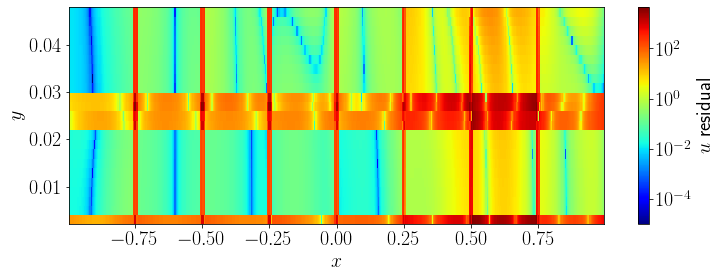

/usr/WS2/diaz64/NM-ROM/nm-rom/lib64/python3.6/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


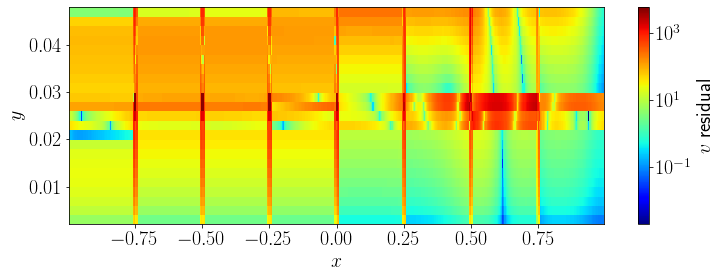

In [20]:
# plot residuals on FD grid
nx_sub, ny_sub = nx//n_sub_x, ny//n_sub_y
nxy_sub = nx_sub*ny_sub
if ddlsrom.hr:
    u_res_list = []
    v_res_list = []
    for i, s in enumerate(ddlsrom.subdomain):
        r = np.zeros(2*s.n_residual)+1e-16
        r[s.hr_ind] = res_list[i]
        u_res_list.append(r[:nxy_sub].reshape(ny_sub, nx_sub))
        v_res_list.append(r[nxy_sub:].reshape(ny_sub, nx_sub))
else:
    u_res_list = [r[:nxy_sub].reshape(ny_sub, nx_sub) for r in res_list]
    v_res_list = [r[nxy_sub:].reshape(ny_sub, nx_sub) for r in res_list]
    
Ures = []
Vres = []
counter = 0
for j in range(n_sub_y):
    Urow = []
    Vrow = []
    for i in range(n_sub_x):
        sub = n_sub_x*j+i
        Urow.append(u_res_list[sub])
        Vrow.append(v_res_list[sub])
    Ures.append(Urow)
    Vres.append(Vrow)
Ures = np.abs(np.bmat(Ures))
Vres = np.abs(np.bmat(Vres)) 

plt.figure(figsize=(12, 4))
plt.pcolormesh(X, Y, Ures, norm=colors.LogNorm(vmin=Ures.min(), vmax=Ures.max()), cmap=cm.jet)
plt.xlabel('$x$')
plt.ylabel('$y$')
cb = plt.colorbar(label='$u$ residual')
plt.show()

plt.figure(figsize=(12, 4))
plt.pcolormesh(X, Y, Vres, norm=colors.LogNorm(vmin=Vres.min(), vmax=Vres.max()), cmap=cm.jet)
plt.xlabel('$x$')
plt.ylabel('$y$')
cb = plt.colorbar(label='$v$ residual')
plt.show()